In [1]:
from IPython.display import display, Latex, Markdown
import numpy as np
from numpy import linalg as LA
import sympy as sp
import control as ctrl
from control import matlab
import math
import cmath
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
                     'figure.figsize':[16,9],
                     'font.size': 22, 
                     'xaxis.labellocation': 'right',
                     'yaxis.labellocation': 'top'});

def root2poly(symbol, *roots):
    x = sp.symbols(str(symbol));
    poly = 1;
    for root in roots:
        poly *=(x-root);
    return poly.expand();

In [2]:
#  Matrizes do sistema
A = np.matrix([[0, 1, 0], [0, 0, 1], [-1, -5, -6]]);
B = np.matrix([[0],[0],[1]]);
C = np.matrix([1, 1, 1]);
D = 0;

# Autovalores desejados
sigma = 0.7;
wn = 10;
u1, u2 = np.roots([1, 2*sigma*wn, wn**2]);
u3 = 10*np.real(u1);
autovalores = [u1, u2, u3];

# Matriz de controlabilidade
Mc = ctrl.ctrb(A,B);

# Teste de controlabilidade
posto_Mc = LA.matrix_rank(Mc);

display(Markdown('### Matriz de estados:'));
display(Latex('$ \mathbf{A} = '+str(sp.latex(sp.Matrix(A)))+'$'));
display(Markdown('### Matriz de entrada:'));
display(Latex('$ \mathbf{B} = '+str(sp.latex(sp.Matrix(B)))+'$'));

display(Markdown('### Autovalores desejados:'));
display(Latex('$ \mathbf{\mu} = '+str(autovalores).replace(',','; \ ').replace('.', ',')+'$'));

display(Markdown('### Matrix de controlabilidade:'));
display(Latex('$ \mathbf{M_{c}} = '+str(sp.latex(sp.Matrix(Mc))).replace('.',',')+' $'));
display(Markdown('### Posto da matriz de controlabilidade:'));
display(Latex('$ \mathrm{posto} \, (\mathbf{M_{c}}) = '+str(posto_Mc)+' $'));

### Matriz de estados:

<IPython.core.display.Latex object>

### Matriz de entrada:

<IPython.core.display.Latex object>

### Autovalores desejados:

<IPython.core.display.Latex object>

### Matrix de controlabilidade:

<IPython.core.display.Latex object>

### Posto da matriz de controlabilidade:

<IPython.core.display.Latex object>

In [3]:
# Equação característica desejada
s, I = sp.symbols('s I');

eq_des = root2poly(s, *autovalores);

# Substituição da matriz A no polinômio desejado phi(A)
ordem = sp.degree(eq_des);
eq_tmp = eq_des - eq_des.coeff(s, 0) + eq_des.coeff(s,0)*I;
eq_tmp = eq_tmp.xreplace({I : sp.Matrix(np.eye(ordem))});

phi = sp.lambdify(s, eq_tmp, 'numpy');

# Fórmula de Ackreman
k = np.array([[*np.zeros(ordem)]]);
k[0][-1] = 1;
K1 = k*LA.inv(Mc)*phi(A);

K2 = ctrl.acker(A,B,autovalores);

display(Markdown('### Equação característica desejada:'));
display(Latex('$ EC(s) = '+str(sp.latex(eq_des)).replace('.',',')+'$'));
display(Markdown('### Matriz $\phi (\mathbf{A})$:'));
display(Latex('$ \phi (\mathbf{A}) = '+str(sp.latex(sp.Matrix(phi(A)))).replace('.',',')+'$'));
display(Markdown('### Matriz de ganho de retroação de estado:'));
display(Latex('$ \mathbf{K} = '+str(sp.latex(sp.Matrix(K1))).replace('.',',')+'$'));
display(Markdown('### Matriz de ganho de retroação de estado calculada por acker():'));
display(Latex('$ \mathbf{K} = '+str(sp.latex(sp.Matrix(K2))).replace('.',',')+'$'));
display(Markdown('### Autovalores obtidos:'));
display(Latex('$ \mathbf{\mu} = '+str(list(LA.eig(A-B*K1)[0])).replace(',','; \ ').replace('.',',')+'$'));

### Equação característica desejada:

<IPython.core.display.Latex object>

### Matriz $\phi (\mathbf{A})$:

<IPython.core.display.Latex object>

### Matriz de ganho de retroação de estado:

<IPython.core.display.Latex object>

### Matriz de ganho de retroação de estado calculada por acker():

<IPython.core.display.Latex object>

### Autovalores obtidos:

<IPython.core.display.Latex object>

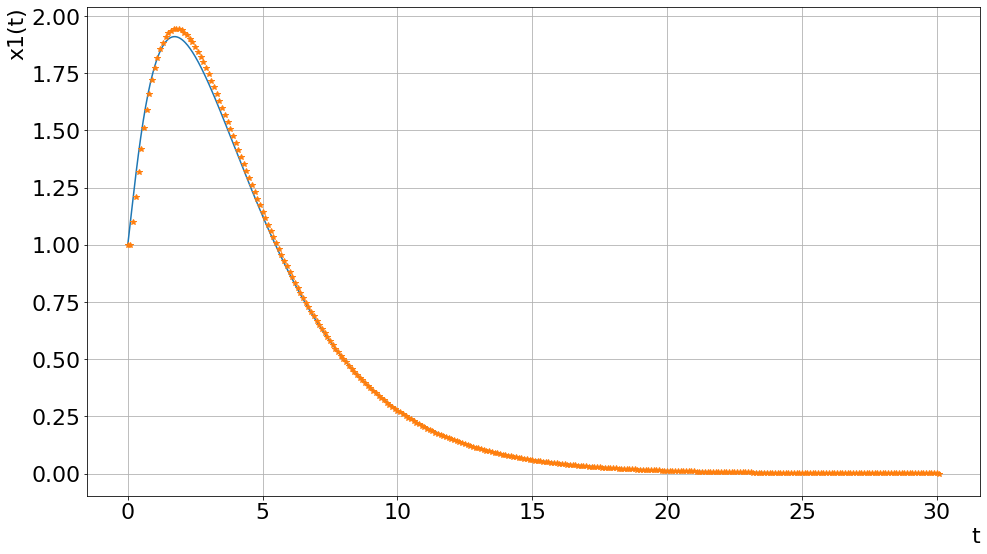

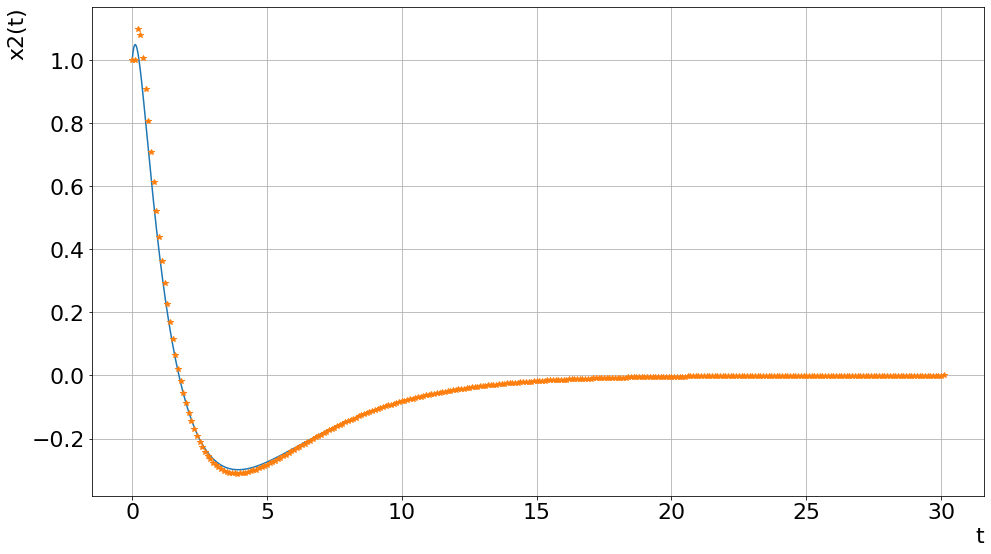

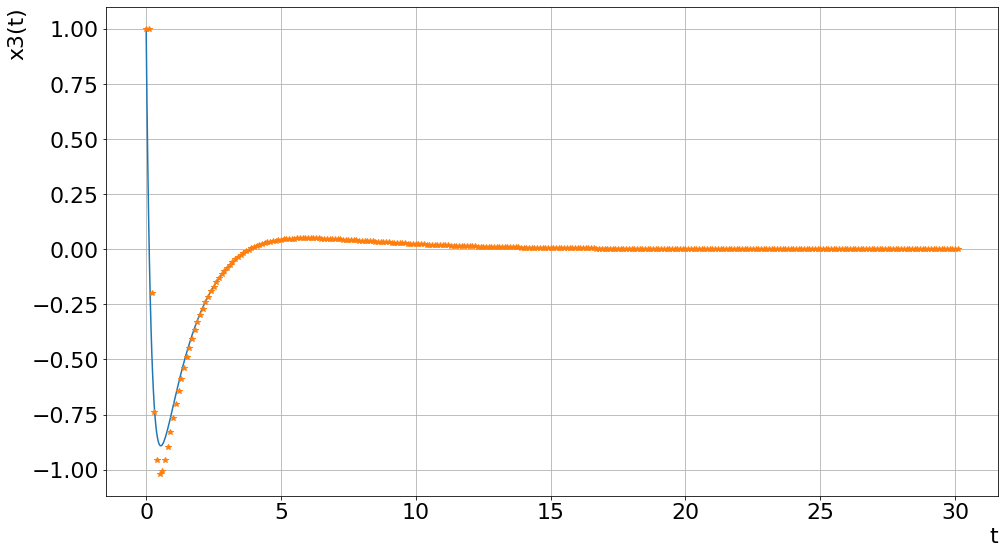

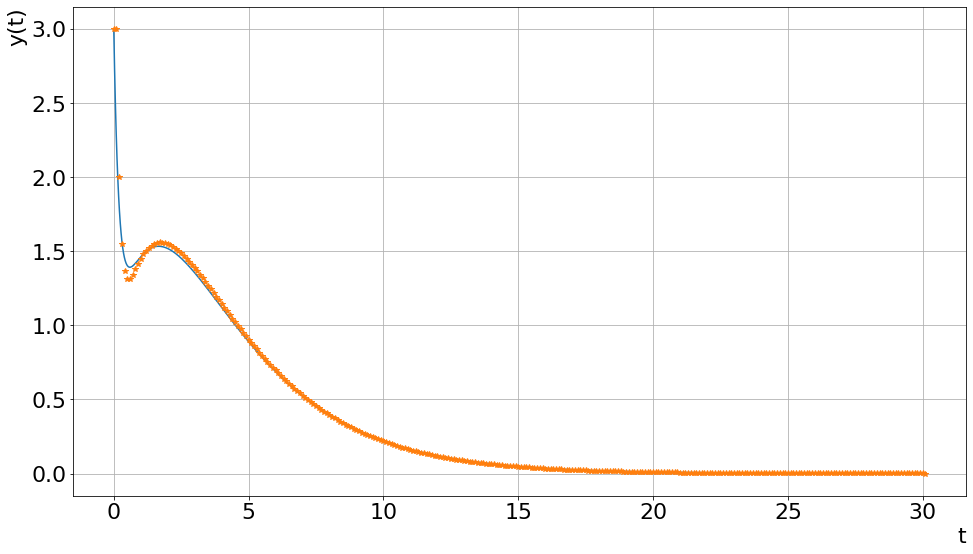

In [4]:
# Sistema de espaço de estados
sistema = ctrl.ss(A,B,C,D);

# Condições Iniciais
x0 = np.matrix([[1], [1], [1]]);

# Simulação do sistema
t = np.linspace(0, 30, 1000);
u = np.zeros(len(t));
Y, t, X = ctrl.matlab.lsim(sistema,u,t,x0);

x1a = X[:,0];
x1b = X[:,1];
x1c = X[:,2];

# Simulação com discretização dos integradores
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)

T = 0.1;
tfinal = 30;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1)
u = np.zeros_like(k);

x1 = np.zeros_like(k);
x2 = np.zeros_like(k);
x3 = np.zeros_like(k);
x1_ponto = np.zeros_like(k);
x2_ponto = np.zeros_like(k);
x3_ponto = np.zeros_like(k);
y = np.zeros_like(k);

# Condições iniciais (podem ser diferentes de zero)
x1[0] = x0[0];  #  para k = 0
x2[0] = x0[1];  #  para k = 0
x3[0] = x0[2];  #  para k = 0
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
x3_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+C[0,2]*x3[0]+D*u[0];  #  para k = 0

for j in range(1,Kmax):
    # Equações dos integradores
    x1[j]=T*x1_ponto[j-1]+x1[j-1];
    x2[j]=T*x2_ponto[j-1]+x2[j-1];    
    x3[j]=T*x3_ponto[j-1]+x3[j-1];
    # Equação diferencial de estados:  Xponto=A*X+B*U
    x1_ponto[j]=A[0,0]*x1[j]+A[0,1]*x2[j]+A[0,2]*x3[j]+B[0]*u[j];  
    x2_ponto[j]=A[1,0]*x1[j]+A[1,1]*x2[j]+A[1,2]*x3[j]+B[1]*u[j]; 
    x3_ponto[j]=A[2,0]*x1[j]+A[2,1]*x2[j]+A[2,2]*x3[j]+B[2]*u[j];  
    # Equação de Saída: Y=C*X+D*U
    y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+C[0,2]*x3[j]+D*u[j];
    
# Comportamento do estado x1                       
plt.figure();
plt.plot(t, x1a, k*T, x1,'*');
plt.xlabel("t");
plt.ylabel("x1(t)");
plt.grid();

# Comportamento do estado x2                       
plt.figure();
plt.plot(t, x1b, k*T, x2,'*');
plt.xlabel("t");
plt.ylabel("x2(t)");
plt.grid();

# Comportamento do estado x3                       
plt.figure();
plt.plot(t, x1c, k*T, x3,'*');
plt.xlabel("t");
plt.ylabel("x3(t)");
plt.grid();

# Comportamento da saída y                      
plt.figure();
plt.plot(t, Y, k*T, y,'*');
plt.xlabel("t");
plt.ylabel("y(t)");
plt.grid();
plt.show();

## Diagrama de blocos

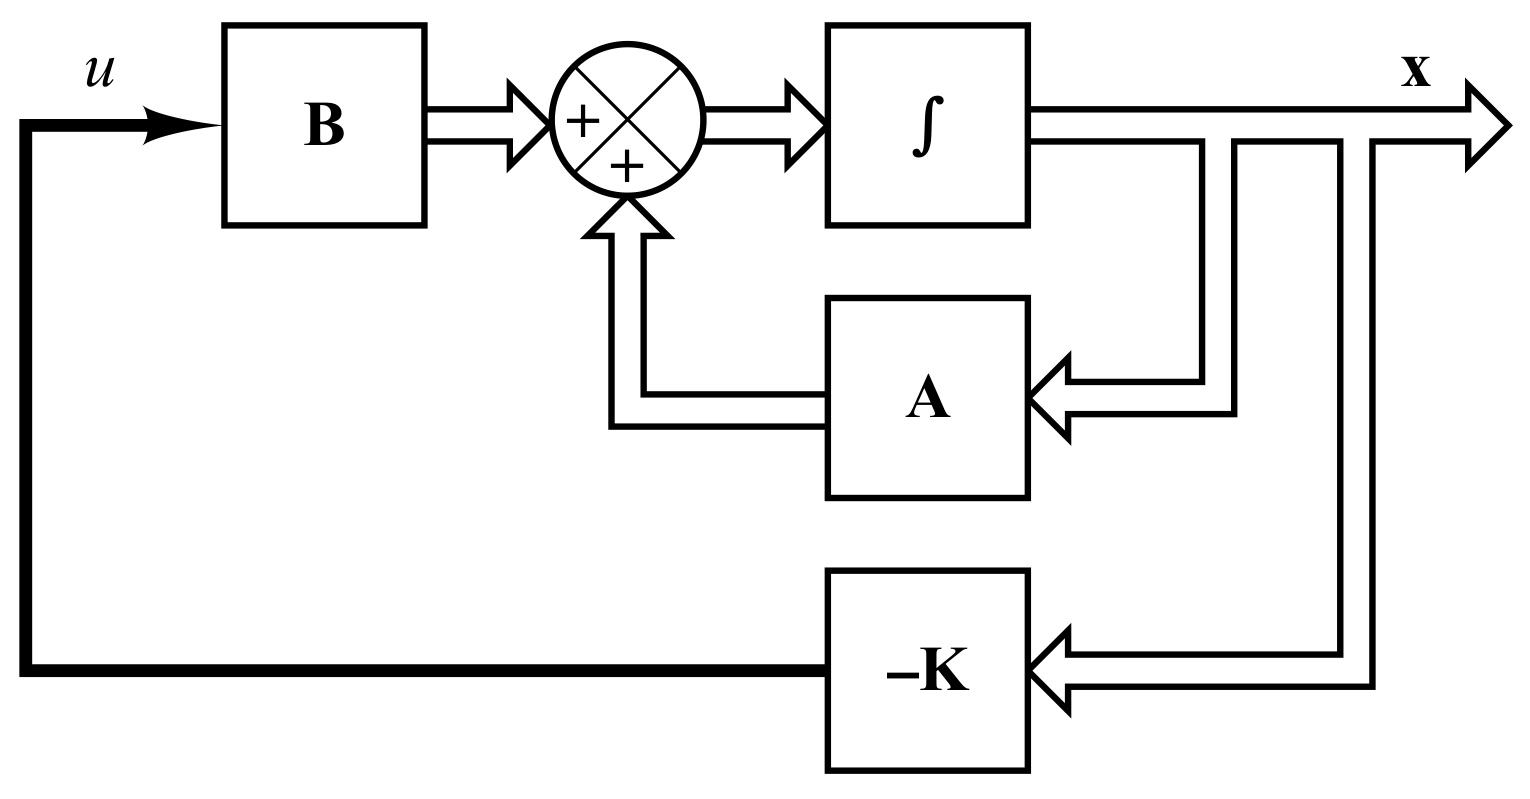